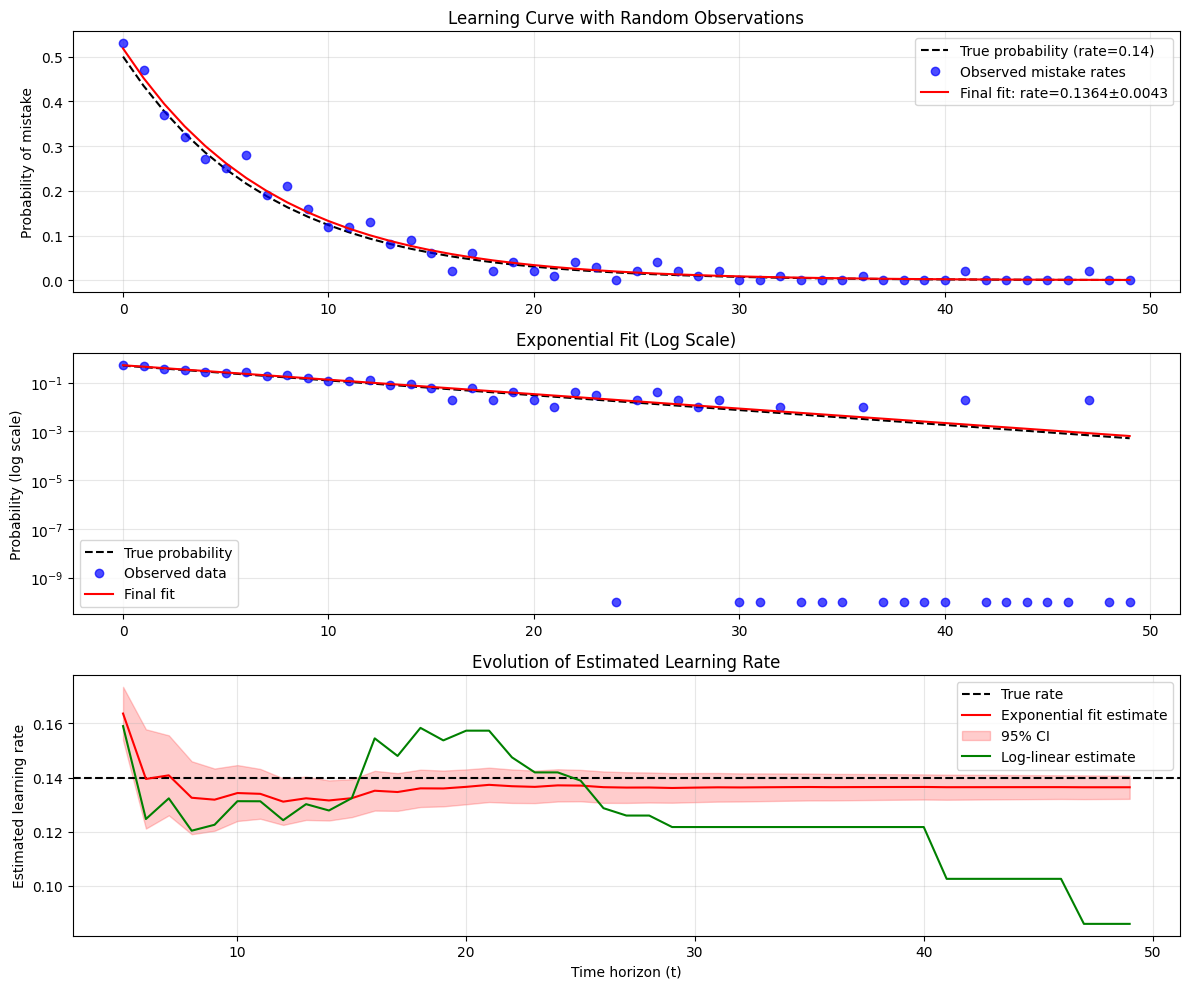

True learning rate: 0.14
Final estimated rate (exp fit): 0.136441 ± 0.004293
Final estimated rate (log-linear): 0.086024
Average rate estimate (last 10 points): 0.136472


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Parameters
true_rate = 0.14  # True learning rate from paper
n_time_points = 50
n_trials_per_time = 100  # Number of trials at each time point
initial_prob = 0.5
min_points_for_estimation = 5  # Minimum points required for a stable estimate

# Generate time points
t_values = np.arange(0, n_time_points, 1)

# True underlying probabilities
true_probs = initial_prob * np.exp(-true_rate * t_values)

# Generate binary outcomes with randomness
np.random.seed(42)  # For reproducibility
observed_mistakes = np.zeros(n_time_points)

for t in range(n_time_points):
    # Run trials at each time point
    mistakes = np.random.random(n_trials_per_time) < true_probs[t]
    observed_mistakes[t] = np.mean(mistakes)  # Fraction of mistakes

# Ensure no zeros for log transform
observed_mistakes = np.clip(observed_mistakes, 1e-10, 1.0)

# Function for exponential curve fitting
def exp_decay(t, r, scale):
    return scale * np.exp(-r * t)

# Arrays to store evolving rate estimates
evolving_rates = np.zeros(n_time_points)
evolving_rates_err = np.zeros(n_time_points)
evolving_rates_log = np.zeros(n_time_points)

# Calculate rate at each time step using all data up to that point
for t_max in range(min_points_for_estimation, n_time_points):
    # Get data up to current time
    t_subset = t_values[:t_max+1]
    p_subset = observed_mistakes[:t_max+1]
    
    # Method 1: Direct exponential fit
    try:
        params, covariance = curve_fit(exp_decay, t_subset, p_subset)
        evolving_rates[t_max] = params[0]  # r parameter
        evolving_rates_err[t_max] = np.sqrt(covariance[0,0])  # std error
    except:
        # If curve_fit fails, use previous estimate
        evolving_rates[t_max] = evolving_rates[t_max-1] if t_max > 0 else np.nan
        evolving_rates_err[t_max] = evolving_rates_err[t_max-1] if t_max > 0 else np.nan
    
    # Method 2: Log-linear regression
    log_p = np.log(p_subset)
    valid_idx = p_subset > 0.01
    if sum(valid_idx) > 2:
        coeffs = np.polyfit(t_subset[valid_idx], log_p[valid_idx], 1)
    else:
        coeffs = np.polyfit(t_subset, log_p, 1)
    evolving_rates_log[t_max] = -coeffs[0]

# Final model fit using all data
params, covariance = curve_fit(exp_decay, t_values, observed_mistakes)
final_rate, final_scale = params
final_rate_err = np.sqrt(covariance[0,0])

# Create plots
plt.figure(figsize=(12, 10))

# Plot 1: Observed data and final fitted curve
plt.subplot(3, 1, 1)
plt.plot(t_values, true_probs, 'k--', label=f'True probability (rate={true_rate})')
plt.plot(t_values, observed_mistakes, 'bo', alpha=0.7, label='Observed mistake rates')
plt.plot(t_values, exp_decay(t_values, final_rate, final_scale), 'r-', 
         label=f'Final fit: rate={final_rate:.4f}±{final_rate_err:.4f}')
plt.title('Learning Curve with Random Observations')
plt.ylabel('Probability of mistake')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Log scale view
plt.subplot(3, 1, 2)
plt.plot(t_values, true_probs, 'k--', label='True probability')
plt.plot(t_values, observed_mistakes, 'bo', alpha=0.7, label='Observed data')
plt.plot(t_values, exp_decay(t_values, final_rate, final_scale), 'r-', label='Final fit')
plt.yscale('log')
plt.ylabel('Probability (log scale)')
plt.title('Exponential Fit (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Evolution of estimated learning rate
plt.subplot(3, 1, 3)
plt.axhline(y=true_rate, color='k', linestyle='--', label='True rate')
valid_idx = ~np.isnan(evolving_rates[min_points_for_estimation:])
t_plot = t_values[min_points_for_estimation:][valid_idx]
rates_plot = evolving_rates[min_points_for_estimation:][valid_idx]
errors_plot = evolving_rates_err[min_points_for_estimation:][valid_idx]

plt.plot(t_plot, rates_plot, 'r-', label='Exponential fit estimate')
plt.fill_between(t_plot, rates_plot-errors_plot, rates_plot+errors_plot, color='r', alpha=0.2, label='95% CI')
plt.plot(t_values[min_points_for_estimation:], evolving_rates_log[min_points_for_estimation:], 'g-', label='Log-linear estimate')
plt.xlabel('Time horizon (t)')
plt.ylabel('Estimated learning rate')
plt.title('Evolution of Estimated Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final estimate statistics
print(f"True learning rate: {true_rate}")
print(f"Final estimated rate (exp fit): {final_rate:.6f} ± {final_rate_err:.6f}")
print(f"Final estimated rate (log-linear): {evolving_rates_log[-1]:.6f}")
print(f"Average rate estimate (last 10 points): {np.mean(evolving_rates[-10:]):.6f}")

In [1]:
from graphviz import Digraph

dot = Digraph(comment='FURTHER+ Algorithm')
dot.attr(rankdir='TB')
dot.node_attr.update(shape='box', style='filled', fillcolor='lightgrey')

# Define nodes
dot.node('env', 'Environment (s_t)')
dot.node('obs_fn', 'Observation Function (O_i)')
dot.node('obs', 'Observations (o_t^i)')
dot.node('agent', 'Agent i')
dot.node('trans_fn', 'Transition Function (T)')
dot.node('next_state', 'Next State (s_{t+1})')
dot.node('reward_fn', 'Reward Function (R_i)')
dot.node('rewards', 'Rewards (r_t^i)')
dot.node('joint_action', 'Joint Action (a_t)')
dot.node('belief', 'Belief State Processing (GRU)')
dot.node('belief_out', 'Updated Belief (b_t^i)')
dot.node('inference', 'Inference Learning Module')
dot.node('encoder', 'Encoder Network\n(predicts z_{t+1}^{-i})')
dot.node('decoder', 'Decoder Network\n(predicts a_t^{-i})')
dot.node('latent', 'Inferred Latent States (z_t^{-i})')
dot.node('rl', 'Reinforcement Learning Module')
dot.node('policy', 'Policy Network\n(π^i(a^i | b_t^i, z_t^{-i}))')
dot.node('value', 'Value Networks\n(q^i(b_t^i, z_t^{-i}, a_t))')
dot.node('update_fn', 'Policy Update Function (U_i)')
dot.node('params', 'Updated Policy Parameters (θ_{t+1}^i)')
dot.node('convergence', 'Convergence to Stationary Distribution (μ(s, b, θ))')

# Define edges as (tail, head) tuples
edges = [
    ('env', 'obs_fn'),
    ('env', 'trans_fn'),
    ('env', 'reward_fn'),
    ('obs_fn', 'obs'),
    ('obs', 'agent'),
    ('agent', 'joint_action'),
    ('joint_action', 'trans_fn'),
    ('trans_fn', 'next_state'),
    ('next_state', 'env'),
    ('reward_fn', 'rewards'),
    ('rewards', 'agent'),
    ('agent', 'belief'),
    ('belief', 'belief_out'),
    ('belief_out', 'rl'),
    ('agent', 'inference'),
    ('inference', 'encoder'),
    ('inference', 'decoder'),
    ('encoder', 'latent'),
    ('decoder', 'latent'),
    ('latent', 'rl'),
    ('agent', 'rl'),
    ('rl', 'policy'),
    ('rl', 'value'),
    ('rl', 'update_fn'),
    ('update_fn', 'params'),
    ('params', 'convergence')
]

# Add edges to the graph
dot.edges(edges)

# Render the diagram to a file
dot.render('f', format='png')

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH